In [1]:
# download nltk stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ofekzini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import json

with open('queries_train.json', 'rt') as f:
  queries = json.load(f)

In [3]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [7]:
def precision_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(predicted_list) == 0:
        return 0.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(predicted_list), 3)
def recall_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(true_set) < 1:
        return 1.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(true_set), 3)
def f1_at_k(true_list, predicted_list, k):
    p = precision_at_k(true_list, predicted_list, k)
    r = recall_at_k(true_list, predicted_list, k)
    if p == 0.0 or r == 0.0:
        return 0.0
    return round(2.0 / (1.0/p + 1.0/r), 3)
def results_quality(true_list, predicted_list):
    p5 = precision_at_k(true_list, predicted_list, 5)
    f1_30 = f1_at_k(true_list, predicted_list, 30)
    print(f"p5: {p5}, f1_30: {f1_30}")
    if p5 == 0.0 or f1_30 == 0.0:
        return 0.0
    return round(2.0 / (1.0/p5 + 1.0/f1_30), 3)

assert precision_at_k(range(10), [1,2,3] , 2) == 1.0
assert recall_at_k(   range(10), [10,5,3], 2) == 0.1
assert precision_at_k(range(10), []      , 2) == 0.0
assert precision_at_k([],        [1,2,3],  5) == 0.0
assert recall_at_k(   [],        [10,5,3], 2) == 1.0
assert recall_at_k(   range(10), [],       2) == 0.0
assert f1_at_k(       [],        [1,2,3],  5) == 0.0
assert f1_at_k(       range(10), [],       2) == 0.0
assert f1_at_k(       range(10), [0,1,2],  2) == 0.333
assert f1_at_k(       range(50), range(5), 30) == 0.182
assert f1_at_k(       range(50), range(10), 30) == 0.333
assert f1_at_k(       range(50), range(30), 30) == 0.75
assert results_quality(range(50), range(5))  == 0.308
assert results_quality(range(50), range(10)) == 0.5
assert results_quality(range(50), range(30)) == 0.857
assert results_quality(range(50), [-1]*5 + list(range(5,30))) == 0.0

p5: 1.0, f1_30: 0.182
p5: 1.0, f1_30: 0.333
p5: 1.0, f1_30: 0.75
p5: 0.0, f1_30: 0.625


In [39]:
import requests
from time import time
# In GCP the public URL for your engine should look like this:
# url = 'http://35.232.59.3:8080'
# In colab, we are going to send HTTP requests to localhost (127.0.0.1)
# and direct them to port where the server is listening (5000).
url = 'http://34.55.107.240:8080/'

# rq = None
qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search', {'query': q}, timeout=35)
#     print(res.status_code)
    duration = time() - t_start
    print(q,duration)
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      # print(pred_wids)
      rq = results_quality(true_wids, pred_wids)
  except:
    pass

  qs_res.append((q, duration, rq))

Human Genome Project DNA mapping 0.8219282627105713
p5: 0.8, f1_30: 0.325
Italian pasta varieties and recipes 0.5421628952026367
p5: 0.2, f1_30: 0.052
Street food around the world 1.427846908569336
p5: 0.4, f1_30: 0.052
Surrealism art Salvador Dalí 0.8005690574645996
p5: 0.6, f1_30: 0.254
Mediterranean diet health benefits 0.540184736251831
p5: 0.4, f1_30: 0.182
Civil Rights Movement 1960s protests 1.0609159469604492
p5: 0.4, f1_30: 0.237
Manhattan Project atomic bomb 0.5182738304138184
p5: 0.6, f1_30: 0.192
Cheese types and production 0.6086208820343018
p5: 0.4, f1_30: 0.384
Anime history Japan Studio Ghibli 0.9432470798492432
p5: 0.6, f1_30: 0.108
Berlin Wall fall reunification 0.9701828956604004
p5: 0.4, f1_30: 0.051
Sushi origins Japan 0.6398468017578125
p5: 0.2, f1_30: 0.107
World War I causes consequences 1.7602272033691406
p5: 0.6, f1_30: 0.104
Higgs Boson discovery physics 0.474484920501709
p5: 0.8, f1_30: 0.205
Golden Age of Hollywood films 1.634272813796997
p5: 0.2, f1_30: 0.

In [21]:
print(qs_res)

[('Human Genome Project DNA mapping', 0.770442008972168, 0.462), ('Italian pasta varieties and recipes', 0.5342898368835449, 0.083), ('Street food around the world', 1.3803160190582275, 0.092), ('Surrealism art Salvador Dalí', 0.7809967994689941, 0.357), ('Mediterranean diet health benefits', 0.5196847915649414, 0.25), ('Civil Rights Movement 1960s protests', 1.0460641384124756, 0.298), ('Manhattan Project atomic bomb', 0.5146729946136475, 0.291), ('Cheese types and production', 0.6116318702697754, 0.392), ('Anime history Japan Studio Ghibli', 0.9329349994659424, 0.183), ('Berlin Wall fall reunification', 0.7096719741821289, 0.09), ('Sushi origins Japan', 0.6157078742980957, 0.139), ('World War I causes consequences', 1.7206196784973145, 0.177), ('Higgs Boson discovery physics', 0.45946216583251953, 0.326), ('Golden Age of Hollywood films', 1.3232111930847168, 0.177), ('Byzantine Empire Constantinople history', 0.5052528381347656, 0.529), ('Turing Machine early computing', 0.7125360965

In [23]:
import pandas as pd
from datetime import datetime
import os
text_weight = 1.9
title_weight = 1.1
pr_weight = 0.5
pv_weight = 0.6


anchor_weight =0

run_desc = f"back to dict, text weight = {text_weight}, title_weight ={title_weight}, anchor_weight = {anchor_weight},pr_weight = {pr_weight},pv_weight = {pv_weight}"
# Add timestamp column
timestamped_qs_res = [(q, duration, rq, datetime.now().strftime('%Y-%m-%d %H:%M:%S'),run_desc) for q, duration, rq in qs_res]

# Convert results to a DataFrame (same as before)
results_df = pd.DataFrame(timestamped_qs_res, columns=['Query', 'Duration', 'Results Quality', 'Timestamp','type'])

# File path
file_path = r'query_results_local.csv'

# Check if the file exists
if os.path.exists(file_path):
    # Append to existing file
    results_df.to_csv(file_path, mode='a', header=False, index=False)
else:
    # Create a new file with header
    results_df.to_csv(file_path, mode='w', header=True, index=False)

In [49]:
res = requests.post(f'{url}/get_pagerank', json=[40434533,13834,16258840])

# Check the status code to see if the request was successful
print(f"Status Code: {res.status_code}")

# Print the response body (content)
try:
    print("Response JSON:", res.json())  # Attempt to parse JSON response
except ValueError:
    print("Response Text:", res.text) 

Status Code: 200
Response JSON: [3.087233908126274e-05, 0.0009814650341033986, 1.9507241383342223e-05]


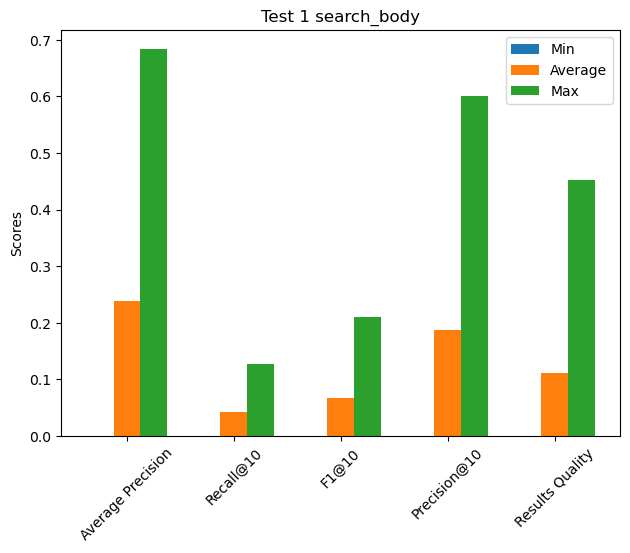

In [215]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Average Precision', 'Recall@10', 'F1@10', 'Precision@10', 'Results Quality']
averages = [0.238, 0.042, 0.068, 0.187, 0.111]
min_values = [0.0, 0.0, 0.0, 0.0, 0.0]
max_values = [0.683, 0.128, 0.211, 0.600, 0.453]

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, min_values, width, label='Min')
rects2 = ax.bar(x, averages, width, label='Average')
rects3 = ax.bar(x + width, max_values, width, label='Max')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Test 1 search_body')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

plt.xticks(rotation=45)
plt.show()